# Benchmarking
## Bacterial dataset

In [116]:
from typing import Any, List, Tuple, Dict
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import h5py
from torch.utils.data import DataLoader

from model.dataset import ToxDataset  # UPDATE THIS
from model.model_architecture import MLP     # UPDATE THIS

In [117]:
MODEL_PATH = "../model/model_output/best_model.pt"
BACTERIAL_H5_FILE = "../benchmark/bacterial/bacterial.h5"
UNREVIEWED_H5_FILE = "../benchmark/uniprot/unreviewed.h5"
#BACTERIAL_H5_FILE = "../benchmark/bacterial/bacterial.h5"

REFERENCE_CSV = "../data/interm/training_data.csv"  # Needed for label encoder
LABEL_COL = "Protein families"

In [118]:
ref_df = pd.read_csv(REFERENCE_CSV)
ref_dataset = ToxDataset(ref_df, [BACTERIAL_H5_FILE], is_train=True, label_col=LABEL_COL)
label_encoder = ref_dataset.le
ref_dataset.close()
print(f"Classes: {list(label_encoder.classes_)}")

Classes: ['Bradykinin-related peptide family', 'CRISP family', 'Cationic peptide family', 'Conotoxin family', 'Disintegrin family', 'Ergtoxin family', 'FARP (FMRFamide related peptide) family', 'Flavin monoamine oxidase family', 'Formicidae venom family', 'Insulin family', 'Limacoditoxin family', 'Long (3 C-C) scorpion toxin superfamily', 'Long (4 C-C) scorpion toxin superfamily', 'Long chain scorpion toxin family', 'MCD family', 'Natriuretic, Bradykinin potentiating peptide family', 'Neurotoxin family', 'Non-disulfide-bridged peptide (NDBP) superfamily', 'PDGF/VEGF growth factor family', 'Peptidase S1 family', 'Phospholipase family', 'Scoloptoxin family', 'Short scorpion toxin superfamily', 'Snaclec family', 'Teretoxin family', 'Three-finger toxin family', 'Vasopressin/oxytocin family', 'Venom Kunitz-type family', 'Venom metalloproteinase (M12B) family', 'nontox', 'other']


In [119]:
with h5py.File(BACTERIAL_H5_FILE, 'r') as f:
    sample_ids = list(f.keys())  # Get all top-level dataset names
    num_samples = len(sample_ids)

    # Optionally check the structure
    print(f"First few samples: {sample_ids[:5]}")
    # Check embedding shape from first sample
    first_sample = f[sample_ids[0]]
    print(f"Embedding shape for first sample: {first_sample.shape}")

print(f"Found {num_samples} samples in H5 file")

First few samples: ['A0A068QWU7', 'A0A068QYK9', 'A0A0A8J2Q4', 'A0A0C5XL88', 'A0A0C6PDA9']
Embedding shape for first sample: (1024,)
Found 10831 samples in H5 file


In [120]:
dummy_df = pd.DataFrame({
    'Entry': sample_ids,
    LABEL_COL: [label_encoder.classes_[0]] * num_samples  # dummy labels
})
dummy_df

,Entry,Protein families
0,A0A068QWU7,Bradykinin-related peptide family
1,A0A068QYK9,Bradykinin-related peptide family
2,A0A0A8J2Q4,Bradykinin-related peptide family
3,A0A0C5XL88,Bradykinin-related peptide family
4,A0A0C6PDA9,Bradykinin-related peptide family
...,...,...
10826,ZP_05940050.1,Bradykinin-related peptide family
10827,ZP_06208163.1,Bradykinin-related peptide family
10828,ZP_06481941.1,Bradykinin-related peptide family
10829,ZP_06486078.1,Bradykinin-related peptide family


In [121]:
bacterial_dataset = ToxDataset(
    dummy_df, [BACTERIAL_H5_FILE],
    label_encoder=label_encoder,
    is_train=False,
    label_col=LABEL_COL
)
bacterial_loader = DataLoader(bacterial_dataset, batch_size=64, shuffle=False)

## UniProt (taxonomy_id:33208) AND (reviewed:false) AND (keyword:KW-0800)

In [122]:
with h5py.File(UNREVIEWED_H5_FILE, 'r') as f:
    sample_ids = list(f.keys())  # Get all top-level dataset names
    num_samples = len(sample_ids)

    # Optionally check the structure
    print(f"First few samples: {sample_ids[:5]}")
    # Check embedding shape from first sample
    first_sample = f[sample_ids[0]]
    print(f"Embedding shape for first sample: {first_sample.shape}")

print(f"Found {num_samples} samples in H5 file")

First few samples: ['A0A016SPW7', 'A0A016U6Y3', 'A0A016UX05', 'A0A016UXP2', 'A0A016UY65']
Embedding shape for first sample: (1024,)
Found 23429 samples in H5 file


In [123]:
dummy_df = pd.DataFrame({
    'Entry': sample_ids,
    LABEL_COL: [label_encoder.classes_[0]] * num_samples  # dummy labels
})
dummy_df

,Entry,Protein families
0,A0A016SPW7,Bradykinin-related peptide family
1,A0A016U6Y3,Bradykinin-related peptide family
2,A0A016UX05,Bradykinin-related peptide family
3,A0A016UXP2,Bradykinin-related peptide family
4,A0A016UY65,Bradykinin-related peptide family
...,...,...
23424,X5IWU3,Bradykinin-related peptide family
23425,X5IXX6,Bradykinin-related peptide family
23426,X5IXZ4,Bradykinin-related peptide family
23427,X5IXZ6,Bradykinin-related peptide family


In [124]:
unreviewed_dataset = ToxDataset(
    dummy_df, [UNREVIEWED_H5_FILE],
    label_encoder=label_encoder,
    is_train=False,
    label_col=LABEL_COL
)
unreviewed_loader = DataLoader(unreviewed_dataset, batch_size=64, shuffle=False)

# Inference

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Based on the error, your saved model has these dimensions:
model = MLP(
    input_dim=1024,   # From error: torch.Size([128, 1024])
    hidden_dim=128,   # From error: torch.Size([128])
    num_family_classes=31  # From error: torch.Size([31, 128])
)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

print(f"Model loaded on {device}")

Model loaded on cpu


In [126]:
unreviewed_dataset.df

,Entry,Protein families,Protein families_encoded
0,A0A016SPW7,Bradykinin-related peptide family,0
1,A0A016U6Y3,Bradykinin-related peptide family,0
2,A0A016UX05,Bradykinin-related peptide family,0
3,A0A016UXP2,Bradykinin-related peptide family,0
4,A0A016UY65,Bradykinin-related peptide family,0
...,...,...,...
23424,X5IWU3,Bradykinin-related peptide family,0
23425,X5IXX6,Bradykinin-related peptide family,0
23426,X5IXZ4,Bradykinin-related peptide family,0
23427,X5IXZ6,Bradykinin-related peptide family,0


In [127]:
def run_inference(
    loader: DataLoader,
    model: torch.nn.Module,
    device: torch.device,
    log_interval: int = 10
) -> Tuple[List[int], List[List[float]]]:
    model.eval()
    all_preds, all_probs = [], []

    with torch.no_grad():
        for i, (features, _) in enumerate(loader):
            features = features.to(device)
            outputs = model(features)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_probs.extend(probs.cpu().tolist())

            if (i + 1) % log_interval == 0:
                processed = (i + 1) * loader.batch_size
                print(f"  • Processed {processed} samples...")

    return all_preds, all_probs


def build_results_df(
    entry_ids: List[Any],
    all_preds: List[int],
    all_probs: List[List[float]],
    label_encoder
) -> pd.DataFrame:
    pred_names  = [label_encoder.classes_[p] for p in all_preds]
    confidences = [max(p) for p in all_probs]

    df = pd.DataFrame({
        "Entry": entry_ids,
        "predicted_class": pred_names,
        "prediction_confidence": confidences
    })

    for i, cls in enumerate(label_encoder.classes_):
        df[f"prob_{cls}"] = [p[i] for p in all_probs]

    return df


def compute_statistics(
    all_preds: List[int],
    all_probs: List[List[float]],
    label_encoder
) -> Dict[str, Any]:
    pred_names  = [label_encoder.classes_[p] for p in all_preds]
    counts      = Counter(pred_names)
    total       = len(all_preds)
    percentages = {cls: cnt / total * 100 for cls, cnt in counts.items()}
    confidences = [max(p) for p in all_probs]

    return {
        "total_samples": total,
        "class_distribution": {
            "counts": dict(counts),
            "percentages": percentages
        },
        "confidence_stats": {
            "mean": float(np.mean(confidences)),
            "median": float(np.median(confidences)),
            "min": float(np.min(confidences)),
            "max": float(np.max(confidences))
        }
    }


def print_summary(stats: Dict[str, Any], name: str) -> None:
    total = stats["total_samples"]
    mean_c = stats["confidence_stats"]["mean"]
    med_c  = stats["confidence_stats"]["median"]
    counts = stats["class_distribution"]["counts"]

    print(f"\n--- {name.upper()} SUMMARY ---")
    print(f"  Total samples: {total:,}")
    print(f"  Avg. confidence: {mean_c:.3f}")
    print(f"  Median confidence: {med_c:.3f}\n")
    print("  Top classes:")
    for cls, cnt in Counter(counts).most_common():
        pct = cnt / total * 100
        print(f"    • {cls}: {cnt:,} ({pct:.1f}%)")


def plot_class_distribution(counts: Dict[str, int], title: str) -> None:
    labels, vals = list(counts.keys()), list(counts.values())
    plt.figure(figsize=(14, 8))
    bars = plt.bar(labels, vals, alpha=0.8)
    plt.yscale('log')
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel("Class")
    plt.ylabel("Count (log scale)")
    plt.xticks(rotation=45, ha="right")

    # annotate bars (positioned for log scale)
    for bar, v in zip(bars, vals):
        y = v if v > 0 else 1  # avoid log(0)
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            y * 1.1,  # 10% above the bar height
            str(v),
            ha="center",
            va="bottom"
        )

    plt.tight_layout()
    plt.show()



def plot_confidence_distribution(
    confidences: List[float],
    title: str = "Prediction Confidence Distribution"
) -> None:
    plt.figure(figsize=(12, 6))
    plt.hist(confidences, bins=50, alpha=0.7, edgecolor='black')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Confidence Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.axvline(np.mean(confidences), linestyle='--', linewidth=2,
                label=f'Mean: {np.mean(confidences):.3f}')
    plt.axvline(np.median(confidences), linestyle='--', linewidth=2,
                label=f'Median: {np.median(confidences):.3f}')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def run_pipeline(
    loader: DataLoader,
    model: torch.nn.Module,
    device: torch.device,
    label_encoder,
    entry_id_col: str = "Entry",
    name: str = None
) -> Dict[str, Any]:
    # 1) Inference
    preds, probs = run_inference(loader, model, device)

    # 2) Pull Entry IDs
    entry_ids = loader.dataset.df[entry_id_col].tolist()

    # 3) Build DataFrame
    df = build_results_df(entry_ids, preds, probs, label_encoder)

    # 4) Compute stats
    stats = compute_statistics(preds, probs, label_encoder)

    # 5) Print and plot
    if name:
        print(f"\n=== Inference on {name} ===")
        print_summary(stats, name)
        plot_class_distribution(
            stats["class_distribution"]["counts"],
            title=f"{name} distribution"
        )
        confidences = [max(p) for p in probs]
        plot_confidence_distribution(
            confidences,
            title=f"{name} confidence distribution"
        )

    return {"df": df, "stats": stats}

  • Processed 640 samples...
  • Processed 1280 samples...
  • Processed 1920 samples...
  • Processed 2560 samples...
  • Processed 3200 samples...
  • Processed 3840 samples...
  • Processed 4480 samples...
  • Processed 5120 samples...
  • Processed 5760 samples...
  • Processed 6400 samples...
  • Processed 7040 samples...
  • Processed 7680 samples...
  • Processed 8320 samples...
  • Processed 8960 samples...
  • Processed 9600 samples...
  • Processed 10240 samples...
  • Processed 10880 samples...
  • Processed 11520 samples...
  • Processed 12160 samples...
  • Processed 12800 samples...
  • Processed 13440 samples...
  • Processed 14080 samples...
  • Processed 14720 samples...
  • Processed 15360 samples...
  • Processed 16000 samples...
  • Processed 16640 samples...
  • Processed 17280 samples...
  • Processed 17920 samples...
  • Processed 18560 samples...
  • Processed 19200 samples...
  • Processed 19840 samples...
  • Processed 20480 samples...
  • Processed 21120 samp

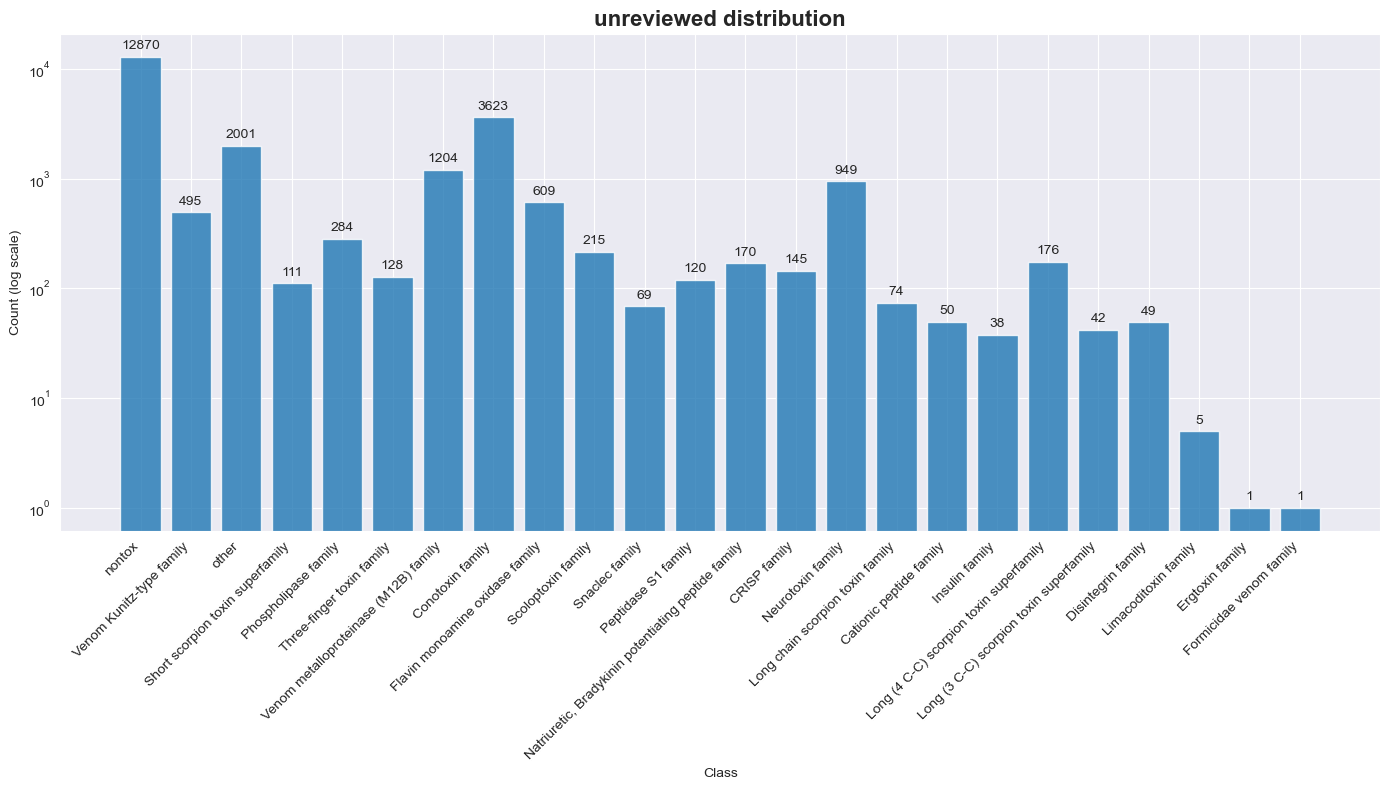

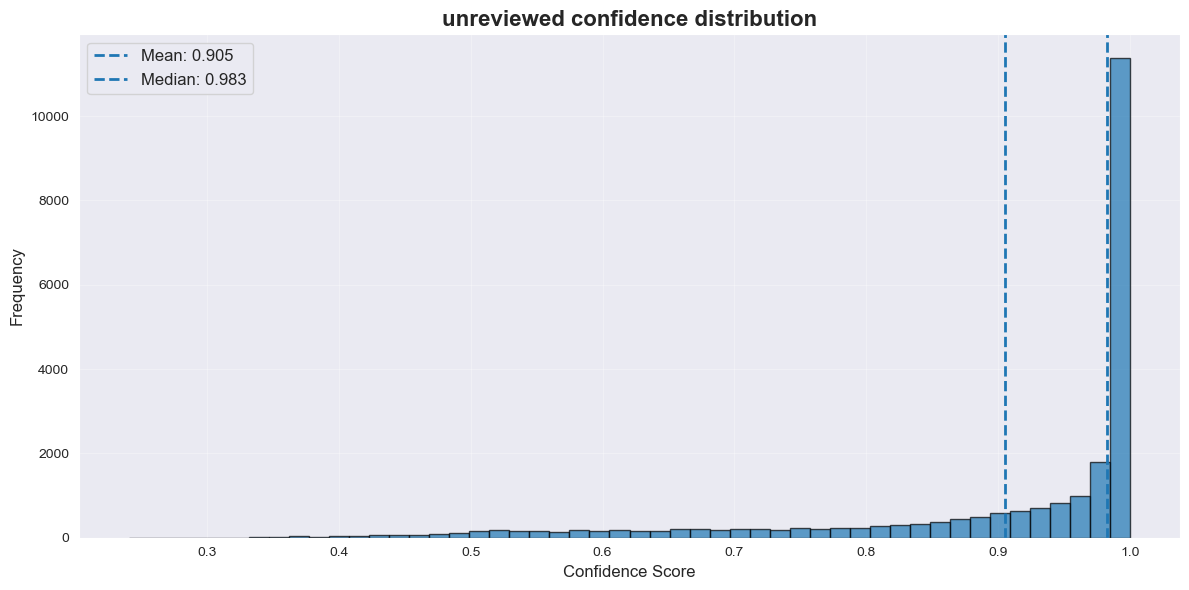

In [128]:
unreviewed_results = run_pipeline(
    loader=unreviewed_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    label_encoder=label_encoder,
    name=f"unreviewed"
)

df_unreviewed = unreviewed_results["df"]
stats_unreviewed = unreviewed_results["stats"]

  • Processed 640 samples...
  • Processed 1280 samples...
  • Processed 1920 samples...
  • Processed 2560 samples...
  • Processed 3200 samples...
  • Processed 3840 samples...
  • Processed 4480 samples...
  • Processed 5120 samples...
  • Processed 5760 samples...
  • Processed 6400 samples...
  • Processed 7040 samples...
  • Processed 7680 samples...
  • Processed 8320 samples...
  • Processed 8960 samples...
  • Processed 9600 samples...
  • Processed 10240 samples...
  • Processed 10880 samples...

=== Inference on bacterial ===

--- BACTERIAL SUMMARY ---
  Total samples: 10,831
  Avg. confidence: 0.967
  Median confidence: 0.996

  Top classes:
    • nontox: 10,761 (99.4%)
    • other: 27 (0.2%)
    • Scoloptoxin family: 14 (0.1%)
    • Cationic peptide family: 14 (0.1%)
    • Neurotoxin family: 8 (0.1%)
    • Conotoxin family: 4 (0.0%)
    • Limacoditoxin family: 2 (0.0%)
    • Non-disulfide-bridged peptide (NDBP) superfamily: 1 (0.0%)


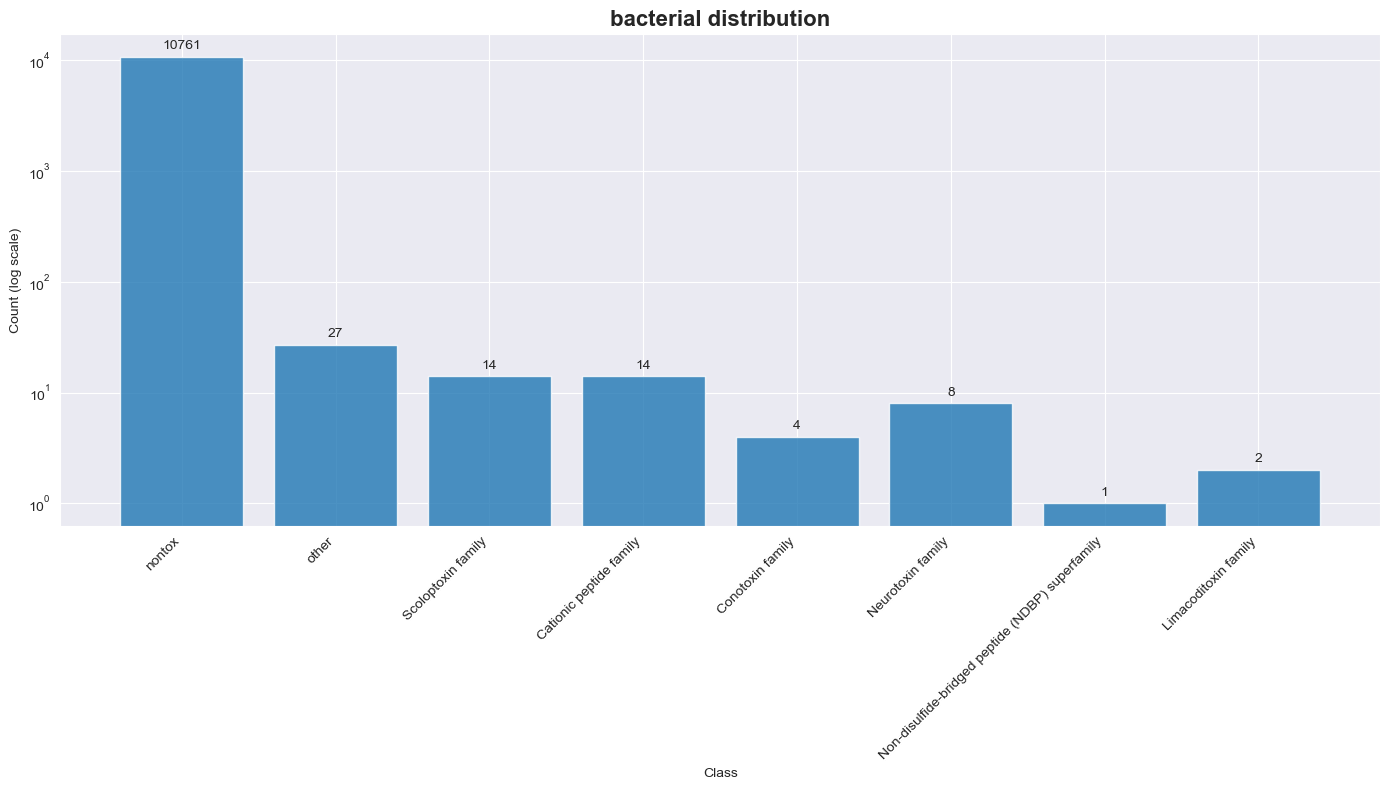

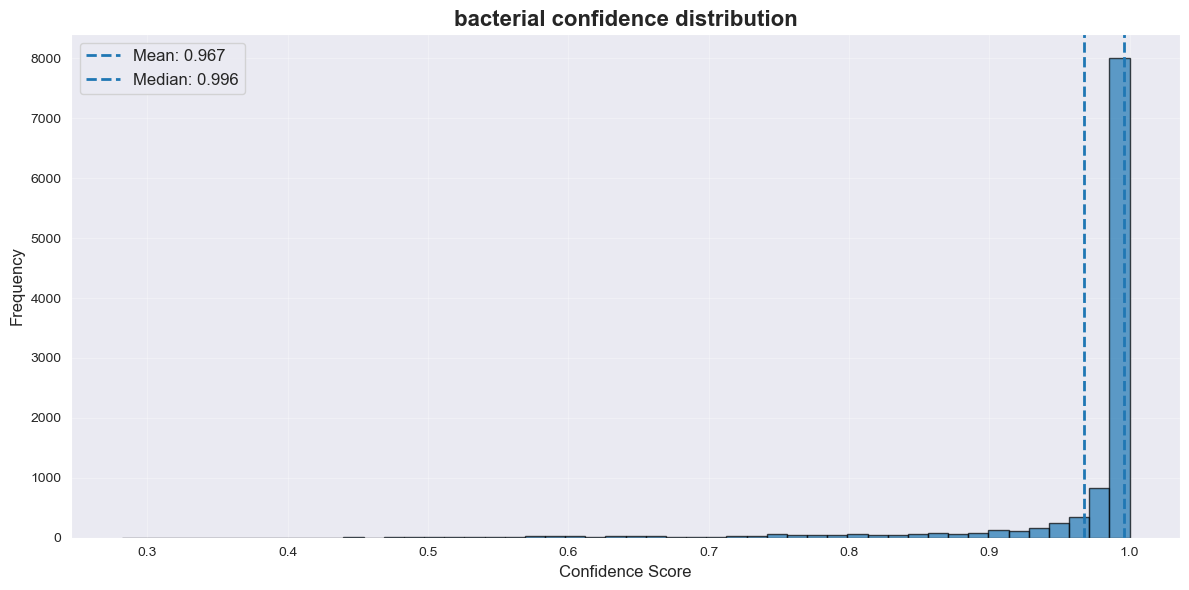

In [129]:
bacterial_results = run_pipeline(
    loader=bacterial_loader,
    model=model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    label_encoder=label_encoder,
    name=f"bacterial"
)

df_bacterial = bacterial_results["df"]
stats_bacterial = bacterial_results["stats"]

In [130]:
df_unreviewed.head()

,Entry,predicted_class,prediction_confidence,prob_Bradykinin-related peptide family,prob_CRISP family,prob_Cationic peptide family,prob_Conotoxin family,prob_Disintegrin family,prob_Ergtoxin family,prob_FARP (FMRFamide related peptide) family,...,prob_Scoloptoxin family,prob_Short scorpion toxin superfamily,prob_Snaclec family,prob_Teretoxin family,prob_Three-finger toxin family,prob_Vasopressin/oxytocin family,prob_Venom Kunitz-type family,prob_Venom metalloproteinase (M12B) family,prob_nontox,prob_other
0,A0A016SPW7,nontox,0.998409,2.799679e-09,3.771792e-10,2.169367e-08,4.895433e-07,1.987415e-06,4.049638e-14,1.142210e-07,...,1.625969e-05,1.134959e-09,6.730128e-11,1.946434e-08,1.597932e-08,8.322905e-08,0.000010,2.995014e-08,0.998409,0.001546
1,A0A016U6Y3,nontox,0.942130,9.919547e-10,5.365734e-06,5.071115e-04,7.859714e-09,1.854953e-08,4.280688e-11,1.745810e-08,...,1.814803e-05,1.494225e-08,1.201830e-08,1.961661e-09,8.549786e-09,7.487599e-09,0.022705,3.991780e-07,0.942130,0.034616
2,A0A016UX05,Venom Kunitz-type family,0.983711,2.963596e-12,2.536407e-08,4.693214e-09,6.290372e-08,3.840002e-08,3.269337e-13,3.779753e-09,...,2.053511e-07,8.029056e-09,8.884541e-09,6.248010e-11,8.721011e-09,9.112140e-10,0.983711,2.901893e-08,0.012458,0.003831
3,A0A016UXP2,Venom Kunitz-type family,0.895868,5.086921e-11,5.290369e-07,8.906850e-08,5.849095e-07,1.098886e-06,3.098732e-11,3.399488e-08,...,3.518803e-05,3.782998e-07,3.029561e-07,6.630959e-09,1.002526e-06,1.086685e-07,0.895868,4.112935e-07,0.038352,0.065736
4,A0A016UY65,Venom Kunitz-type family,0.602363,1.715138e-10,7.051793e-07,3.843893e-07,7.907548e-06,4.964924e-06,1.841808e-11,3.786299e-07,...,6.692777e-04,1.137836e-06,6.768940e-07,6.223271e-08,2.027811e-06,4.839140e-07,0.602363,7.886585e-07,0.171630,0.225287


In [131]:
df_bacterial.head()

,Entry,predicted_class,prediction_confidence,prob_Bradykinin-related peptide family,prob_CRISP family,prob_Cationic peptide family,prob_Conotoxin family,prob_Disintegrin family,prob_Ergtoxin family,prob_FARP (FMRFamide related peptide) family,...,prob_Scoloptoxin family,prob_Short scorpion toxin superfamily,prob_Snaclec family,prob_Teretoxin family,prob_Three-finger toxin family,prob_Vasopressin/oxytocin family,prob_Venom Kunitz-type family,prob_Venom metalloproteinase (M12B) family,prob_nontox,prob_other
0,A0A068QWU7,nontox,0.997119,9.149294e-09,1.239557e-09,0.001062,0.000005,1.739077e-09,8.225025e-10,4.561873e-08,...,0.000020,5.891287e-08,1.905989e-08,4.815643e-06,2.020959e-08,2.010498e-07,3.775699e-08,2.496988e-07,0.997119,0.001779
1,A0A068QYK9,nontox,0.996508,1.114508e-08,1.507457e-09,0.001431,0.000007,2.834996e-09,8.543465e-10,6.085423e-08,...,0.000034,7.221988e-08,2.763510e-08,6.227846e-06,2.406711e-08,1.929373e-07,4.328061e-08,2.483926e-07,0.996508,0.002001
2,A0A0A8J2Q4,nontox,0.991044,1.055702e-08,1.372849e-05,0.000001,0.000012,1.549833e-07,1.838220e-08,3.098809e-07,...,0.001617,1.680396e-06,9.765209e-05,9.492901e-06,5.669430e-05,1.465958e-06,2.113660e-07,3.362499e-06,0.991044,0.007039
3,A0A0C5XL88,other,0.570862,1.995773e-07,7.363184e-05,0.000008,0.000001,1.383603e-07,4.752392e-07,2.457355e-06,...,0.003302,5.021736e-06,2.758058e-06,2.787601e-08,5.463122e-06,3.740196e-06,9.766343e-05,8.368040e-06,0.422824,0.570862
4,A0A0C6PDA9,nontox,0.994957,5.319809e-07,3.187184e-09,0.000502,0.001322,6.961843e-07,1.238543e-10,1.625018e-05,...,0.000125,1.715483e-08,1.007817e-07,3.320996e-04,1.087837e-07,5.653958e-06,2.988755e-08,6.847461e-07,0.994957,0.002629


In [132]:
# plt.figure(figsize=(12, 6))
# plt.hist(confidences, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
# plt.title('Prediction Confidence Distribution', fontsize=16, fontweight='bold')
# plt.xlabel('Confidence Score', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.axvline(np.mean(confidences), color='red', linestyle='--', linewidth=2,
#             label=f'Mean: {np.mean(confidences):.3f}')
# plt.axvline(np.median(confidences), color='orange', linestyle='--', linewidth=2,
#             label=f'Median: {np.median(confidences):.3f}')
# plt.legend(fontsize=12)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()